# Module 5 — Radial Velocities & Spectroscopy

Hands-on: (A) simulate radial velocity (RV) data and fit a Keplerian orbit; (B) how to fetch real RV time series
from the NASA Exoplanet Archive bulk 'RADIAL' dataset and process it locally. This notebook gives code you can
run locally to analyze real RV measurements once you download the RADIAL bulk file (instructions included).

**Note:** downloading the full RADIAL dataset from the Exoplanet Archive requires `wget` or a browser; the
notebook shows how to run the provided `wget_RADIAL.bat` script to fetch and extract files.

In [14]:
# Install required packages (run once)
# Uncomment if needed
# !pip install numpy scipy matplotlib pandas astropy lmfit

import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
from math import pi
print('Ready: numpy, scipy, matplotlib, pandas available')

Ready: numpy, scipy, matplotlib, pandas available


## Part A — Simulate an RV curve and fit a Keplerian

We'll simulate a single-planet RV signal (circular orbit for simplicity), add noise and an instrument offset,
then fit the semi-amplitude K, period P, and phase (t0) using a non-linear least-squares optimizer. This
teaches the fitting workflow you'll use on real data.

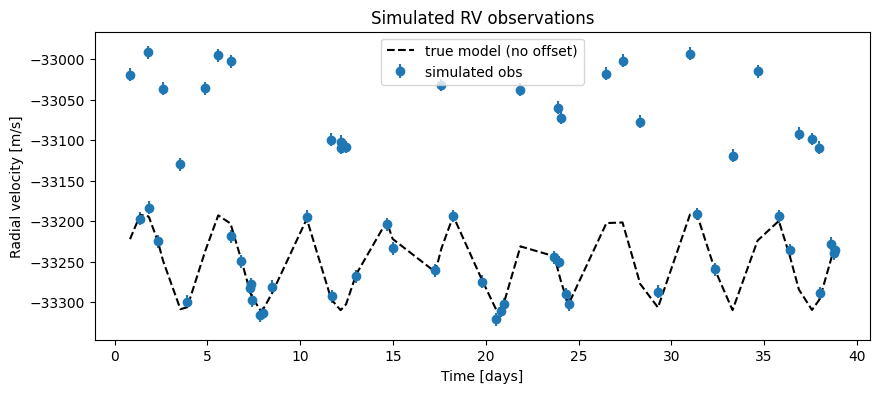

Fit results: K=59.91 m/s, P=4.23071 d, t0=0.5032 d


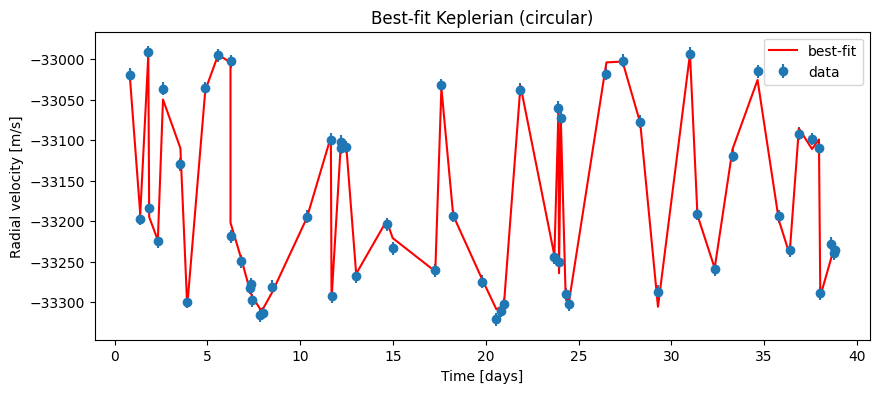

In [15]:
# Keplerian RV (circular) model and fitting demo
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import least_squares

def rv_model_circular(t, K, P, t0, gamma):
    """Simple circular Keplerian RV model.
    t: times (days)
    K: semi-amplitude (m/s)
    P: period (days)
    t0: time of periastron (days) -- for circular orbit it's a phase reference
    gamma: systemic velocity (m/s)
    """
    phi = 2*np.pi*(t - t0)/P
    return gamma + K * np.sin(phi)

# True parameters (simulate)
K_true = 60.0      # m/s
P_true = 4.23077   # days (51 Peg-like)
t0_true = 0.5
gamma_true = -33.25  # km/s style zero point, but we'll keep m/s units for K/gamma
# We'll express gamma in m/s as well for consistency
gamma_true_ms = gamma_true * 1000.0

# observation times (days)
np.random.seed(42)
t = np.sort(np.random.uniform(0, 40, 60))  # 60 observations over 40 days
rv_true = rv_model_circular(t, K_true, P_true, t0_true, gamma_true_ms)

# add instrument offsets & noise (simulate 2 instruments)
inst = np.random.choice([0,1], size=len(t))
offsets = {0: 0.0, 1: 200.0}  # m/s offset for instrument 1
rv_obs = rv_true + np.array([offsets[i] for i in inst]) + np.random.normal(0, 8.0, size=len(t))
rv_err = np.full_like(rv_obs, 8.0)

plt.figure(figsize=(10,4))
plt.errorbar(t, rv_obs, yerr=rv_err, fmt='o', label='simulated obs')
plt.plot(t, rv_true, 'k--', label='true model (no offset)')
plt.xlabel('Time [days]'); plt.ylabel('Radial velocity [m/s]')
plt.legend(); plt.title('Simulated RV observations')
plt.show()

# Fit model: parameters: K, P, t0, gamma0, gamma1 (gamma per instrument)
def pack_params(x):
    K, P, t0, g0, g1 = x
    return K, P, t0, {0:g0, 1:g1}

def residuals(x, t, rv, rv_err, inst):
    K, P, t0, gammas = pack_params(x)
    model = np.array([gammas[i] for i in inst]) + K*np.sin(2*np.pi*(t - t0)/P)
    return (rv - model)/rv_err

# initial guess
x0 = [50.0, 4.2, 0.0, -33250.0, -33050.0]  # gamma in m/s

res = least_squares(residuals, x0, args=(t, rv_obs, rv_err, inst))
K_fit, P_fit, t0_fit, gammas_fit = pack_params(res.x)
print(f'Fit results: K={K_fit:.2f} m/s, P={P_fit:.5f} d, t0={t0_fit:.4f} d')

# plot fit
model_fit = np.array([gammas_fit[i] for i in inst]) + K_fit*np.sin(2*np.pi*(t - t0_fit)/P_fit)
plt.figure(figsize=(10,4))
plt.errorbar(t, rv_obs, yerr=rv_err, fmt='o', label='data')
plt.plot(t, model_fit, 'r-', label='best-fit')
plt.xlabel('Time [days]'); plt.ylabel('Radial velocity [m/s]')
plt.legend(); plt.title('Best-fit Keplerian (circular)')
plt.show()

## Part B — Working with real radial velocity datasets

This notebook won't automatically fetch the entire RADIAL archive for you, but it shows a robust workflow:

1. Download the RADIAL bulk dataset from the NASA Exoplanet Archive Bulk Data page: 

- Visit: https://exoplanetarchive.ipac.caltech.edu/bulk_data_download/ and click the `RADIAL` wget script link (or run the provided `wget_RADIAL.bat`).

2. The wget script downloads a directory containing many small files (one per literature RV time series). Each file is an ASCII table with a header describing the star. After you download and extract, run the cell below to scan the folder and find files for a target star (e.g., '51 Peg').

### How to download the RADIAL dataset (example)

If you have `wget` installed, download the RADIAL wget script from the bulk data page and run it:

```bash
# fetch the wget script (from the website) and run it
wget https://exoplanetarchive.ipac.caltech.edu/bulk_downloads/wget_RADIAL.bat
# open the .bat file to see the actual wget commands, or run with bash/wget to download
bash wget_RADIAL.bat
```

After extraction you'll have a directory full of RV tables which you can scan with the cell above.

## Next steps / advanced fitting

- Use `radvel`, `exoplanet`, or `juliet` for full Keplerian fitting including eccentricity, multiple planets, and jitter terms.
- Add Gaussian Process noise modeling to handle stellar activity.
- If you'd like, I can prepare a notebook that downloads the RADIAL dataset for you and runs the selection & fit for a chosen star (e.g., 51 Peg) — tell me whether you want me to create that file here.

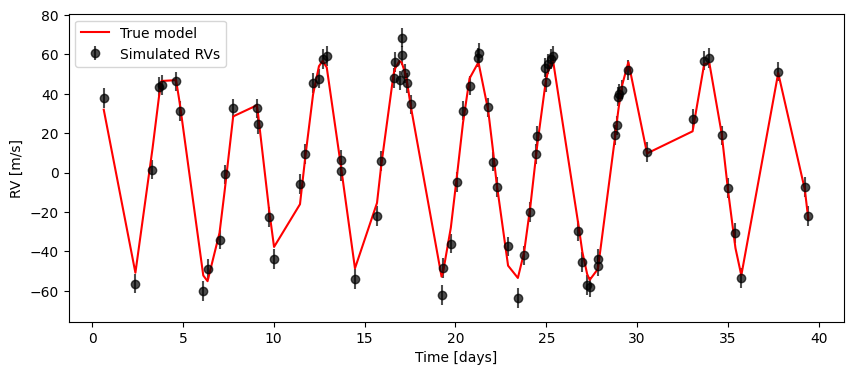

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Published parameters for 51 Peg b (from Werner et al. / NASA Exoplanet Archive summary)
P = 4.230785  # days
K = 55.94     # m/s
e = 0.013     # small eccentricity
w = 0.0       # argument of periastron (radians) — approximate
t0 = 0.0      # phase zeroing

def kepler_E(M, e):
    E = M.copy()
    for _ in range(50):
        f = E - e * np.sin(E) - M
        df = 1 - e * np.cos(E)
        E = E - f/df
    return E

def rv_model(t, P, K, e, w, t0, gamma=0.0):
    M = 2*np.pi*(t - t0)/P
    E = kepler_E(M, e)
    nu = 2 * np.arctan2(np.sqrt(1+e) * np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))
    return gamma + K * (np.cos(nu + w) + e * np.cos(w))

# simulate times + noise
np.random.seed(123)
t = np.sort(np.random.uniform(0, 40, 80))
rv_true = rv_model(t, P, K, e, w, t0)
rv_obs = rv_true + np.random.normal(0, 5.0, size=len(t))
rv_err = np.full_like(rv_obs, 5.0)

plt.figure(figsize=(10,4))
plt.errorbar(t, rv_obs, yerr=rv_err, fmt='o', color='k', alpha=0.7, label='Simulated RVs')
plt.plot(t, rv_true, 'r-', label='True model')
plt.xlabel('Time [days]')
plt.ylabel('RV [m/s]')
plt.legend()
plt.show()
